In [ ]:
# Mount Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd '/content/gdrive/My Drive/Masters_Thesis'


Mounted at /content/gdrive
/content/gdrive/My Drive/Masters_Thesis


In [ ]:
!pip install stepmix # library used to build LCA model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stepmix.stepmix import StepMix

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(42)

In [ ]:
# Provide the filename of your Excel file
file_name = 'preprocessed_reduced_pcaCV.xlsx'

# Read the Excel file into a pandas DataFrame
reduced_pcaSC = pd.read_excel(file_name)

In [ ]:
skills = reduced_pcaSC[reduced_pcaSC['maingroup'] == 'Competenties']
len(skills.answer.unique())

# Above gives: array(['content', 'process', 'socialskills', 'complexproblemsolving',
#       'technicalskills', 'systemskills', 'resourcemanagementskills'],

7

#Splitting data into answers for skills test

In [ ]:
# Specify the column names you want to keep
columns_to_keep = ['question_id', 'maingroup', 'level1subgroup']

# Subset the DataFrame using the specified columns
sk = skills.loc[:, columns_to_keep]

sk = sk.drop(['maingroup'], axis=1)
qs = sk.drop_duplicates(subset='question_id')
qs = qs.sort_values('level1subgroup')
qs

# Create the 'short_name' column
qs['short_name'] = ''

count_cont = 1
count_p = 1
count_so = 1
count_cp = 1
count_t = 1
count_sy = 1
count_rm = 1
for index, row in qs.iterrows():
    if row['level1subgroup'] == 'content':
        qs.at[index, 'short_name'] = f'cont{count_cont}'
        count_cont += 1

    elif row['level1subgroup'] == 'process':
        qs.at[index, 'short_name'] = f'pro{count_p}'
        count_p += 1

    elif row['level1subgroup'] == 'socialskills':
        qs.at[index, 'short_name'] = f'scs{count_so}'
        count_so += 1

    elif row['level1subgroup'] == 'complexproblemsolving':
        qs.at[index, 'short_name'] = f'cps{count_cp}'
        count_cp += 1

    elif row['level1subgroup'] == 'technicalskills':
        qs.at[index, 'short_name'] = f'tec{count_t}'
        count_t += 1

    elif row['level1subgroup'] == 'systemskills':
        qs.at[index, 'short_name'] = f'sys{count_sy}'
        count_sy += 1

    else:
        qs.at[index, 'short_name'] = f'rms{count_rm}'
        count_rm += 1

qs

,question_id,level1subgroup,short_name
375,2551,complexproblemsolving,cps1
359,2535,content,cont1
360,2536,content,cont2
361,2537,content,cont3
362,2538,content,cont4
363,2539,content,cont5
364,2540,content,cont6
365,2541,process,pro1
366,2542,process,pro2
367,2543,process,pro3


In [ ]:
n_qs = qs.drop(['level1subgroup'], axis=1)

# merging (left join) studeies to orginal dataframe
new_qs = pd.merge(skills, n_qs, on='question_id', how='left')
new_qs.head(3)

,question_id,dossier_id,answeredTest_id,question,type,label,datetime,maingroup,maingroup_id,faculty,level1subgroup,level1subgroup_id,answer,short_name
0,2535,2112,13108,question.id_2535,likert/likert7puntslegeschaalpositief,"Ik heb uitstekend inzicht in geschreven tekst,...",2021-09-14 13:10:35,Competenties,525,Faculteit Geesteswetenschappen,content,\N,0.666667,cont1
1,2536,2112,13108,question.id_2536,likert/likert7puntslegeschaalpositief,Ik ben erg goed in het geven van volledige aan...,2021-09-14 13:10:35,Competenties,525,Faculteit Geesteswetenschappen,content,\N,0.833333,cont2
2,2537,2112,13108,question.id_2537,likert/likert7puntslegeschaalpositief,Ik kan uitstekend schriftelijk communiceren al...,2021-09-14 13:10:35,Competenties,525,Faculteit Geesteswetenschappen,content,\N,0.666667,cont3


In [ ]:
# Create pivot table for Questions
qs_data = pd.pivot_table(new_qs, values='answer', index='dossier_id', columns='short_name')

# Reset the index of 'qs_data'
qs_data = qs_data.reset_index()
qs_data = qs_data.rename_axis(None, axis=1)

# Remove NAN values
qs_data.replace('', np.nan, inplace=True)
qs_data = qs_data.dropna()
qs_data

,dossier_id,cont1,cont2,cont3,cont4,cont5,cont6,cps1,pro1,pro2,...,scs3,scs4,scs5,scs6,tec1,tec2,tec3,tec4,tec5,tec6
0,2112,0.666667,0.833333,0.666667,0.500000,0.166667,0.166667,0.500000,0.666667,0.833333,...,0.333333,0.333333,0.666667,0.833333,0.000000,0.500000,0.333333,0.500000,0.000000,0.166667
1,42916,0.500000,0.666667,0.500000,0.333333,0.666667,0.666667,0.333333,0.500000,0.166667,...,0.500000,0.333333,0.500000,0.333333,0.500000,0.500000,0.500000,0.500000,0.333333,0.333333
2,47861,0.666667,0.666667,0.500000,0.500000,0.833333,0.666667,0.333333,0.500000,0.666667,...,0.333333,0.333333,0.500000,0.500000,0.666667,0.500000,0.333333,0.500000,0.666667,0.500000
3,50367,0.333333,0.833333,0.333333,0.666667,0.500000,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.333333,0.833333,0.666667,0.333333,0.666667,0.333333,0.333333,0.500000,0.500000
4,55937,0.666667,0.500000,0.666667,0.333333,0.333333,0.666667,0.666667,0.833333,0.666667,...,0.166667,0.000000,0.833333,0.000000,0.166667,0.666667,0.333333,0.666667,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,91894,0.666667,0.500000,0.666667,0.500000,0.666667,0.500000,0.666667,0.833333,0.833333,...,0.500000,0.666667,0.500000,0.666667,0.500000,0.666667,0.500000,0.166667,0.166667,0.666667
432,91908,0.666667,0.500000,0.666667,0.500000,0.666667,0.500000,0.666667,0.666667,0.666667,...,0.500000,0.500000,0.833333,0.500000,0.000000,0.500000,0.166667,0.500000,0.333333,0.500000
433,91927,0.500000,0.500000,0.500000,0.500000,0.333333,0.333333,0.500000,0.666667,0.500000,...,0.333333,0.333333,0.500000,0.500000,0.000000,0.500000,0.166667,0.333333,0.000000,0.333333
434,91928,0.833333,0.833333,0.666667,0.666667,0.666667,0.666667,0.833333,0.666667,0.833333,...,0.666667,0.666667,0.666667,0.500000,0.833333,0.500000,0.833333,0.833333,0.666667,0.666667


No need to sort the columns

In [ ]:
model = qs_data.drop('dossier_id', axis=1)
model

data_lca = model

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# creating X variable to use as to not effect the model data
X = model

# Define the range of cluster numbers to test
n_clusters_range = range(2, 10)

# Initialize dictionaries to store the metrics
metrics = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'n_clusters': []
}

# Loop over the cluster numbers and perform clustering
for i, n_clusters in enumerate(n_clusters_range):

    # Run hierarchical clustering using the ward linkage method
    ward_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ward_cluster.fit(X)

    #Extract the labels and linkage matrix
    ward_labels = ward_cluster.labels_
    linkage_matrix = ward_cluster.children_

    # Extract the cluster centroids from the linkage matrix
    centroids = []
    for j in range(n_clusters):
        indices = ward_labels == j
        centroid = X[indices].mean(axis=0)
        centroids.append(centroid)
    kmeans_cluster = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=0)
    kmeans_cluster.fit(X)
    cluster_labels = kmeans_cluster.labels_

    # Calculate the metrics for the current cluster assignment
    inertia = kmeans_cluster.inertia_
    silhouette = silhouette_score(X, kmeans_cluster.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans_cluster.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans_cluster.labels_)

    # Store the metrics in the dictionary
    metrics['silhouette'].append(silhouette)
    metrics['calinski_harabasz'].append(calinski_harabasz)
    metrics['davies_bouldin'].append(davies_bouldin)
    metrics['n_clusters'].append(n_clusters)

# Convert the metrics dictionary to a Pandas dataframe
metrics_df = pd.DataFrame(metrics)

metrics_df

,silhouette,calinski_harabasz,davies_bouldin,n_clusters
0,0.143404,80.615248,2.198169,2
1,0.128133,70.059234,2.044634,3
2,0.094021,56.116102,2.223165,4
3,0.088632,49.237678,2.247401,5
4,0.061114,42.540569,2.566526,6
5,0.065203,39.503739,2.429175,7
6,0.061807,35.226168,2.437347,8
7,0.064078,33.148943,2.395958,9


<Axes: xlabel='PC1', ylabel='PC2'>

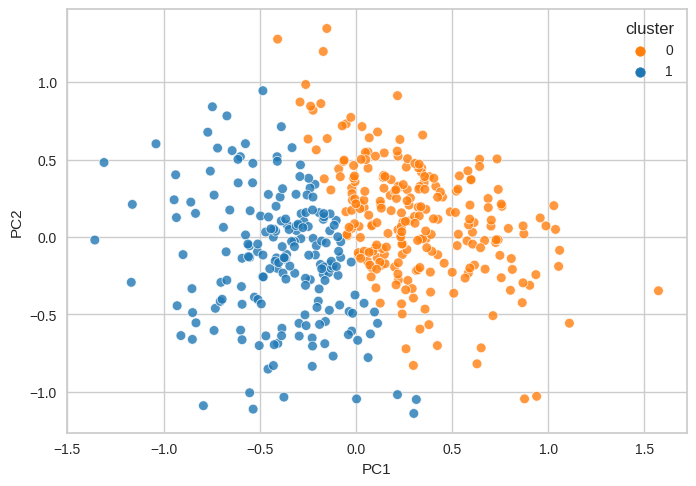

In [ ]:
# Creating K-means Cluster Model
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

seed = 1234 # Used for reproducibility

kmeans = KMeans(n_clusters=2, n_init = 10, random_state=seed)
k_fit = kmeans.fit(model)
centroids = kmeans.cluster_centers_
predictions = k_fit.labels_

# 2 components visualizations
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(model),columns=['PC1','PC2'])

# To maintain cluster colours to allow for easier comparison between cluster plots
color_dict = dict({0: sns.color_palette("tab10")[1], 1: sns.color_palette("tab10")[0]})

pca_data['cluster'] = pd.Categorical(predictions)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, palette=color_dict, alpha=0.8)

In [ ]:
#pca_data.to_excel('pcaCV_skills_clusters.xlsx', index=False)

#Latent Class Analysis

In [ ]:
from sklearn.model_selection import ParameterGrid

# Create LCA model
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123, n_init=10)

grid = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_steps' : [1]
}

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])


# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(data_lca)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(data_lca))
    results['bic'].append(model.bic(data_lca))

# Save results to a dataframe
results = pd.DataFrame(results)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:01<00:00,  5.53it/s, max_LL=-1.15e+3, max_avg_LL=-2.66]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 23 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.9646 0.0354 0.9579 0.0421 0.9945 0.0055 0.9878 0.0122 1.0000 0.0000
 0.9904 0.0096 0.9935 0.0065 0.9827 0.0173 1.0000 0.0000 0.9933 0.0067
 0.9894 0.0106 0.9822 0.0178 1.0000 0.0000 0.9891 0.0109 1.0000 0.0000
 0.9506 0.0494 0.9972 0.0028 0.9683 0.0317 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [0.6328 0.3672 0.6746 0.3254 0.7310 0.2690 0.7057 0.2943 0.9663 0.0337
 0.8916 0.1084 0.8385 0.1615 0.7211 0.2789 0.8147 0.1853 0.8059 0.1941
 0.8478 0.1522 0.6399 0.3601 0.8315 0.1685 0.6975 0.3025 0.8147 0.1853
 0.6

Initializations (n_init) : 100%|██████████| 10/10 [00:08<00:00,  1.18it/s, max_LL=-1.12e+3, max_avg_LL=-2.59]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 23 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.9604 0.0396 0.9635 0.0365 0.9919 0.0081 0.9903 0.0097 1.0000 0.0000
 0.9951 0.0049 0.9947 0.0053 0.9850 0.0150 1.0000 0.0000 0.9949 0.0051
 0.9947 0.0053 0.9921 0.0079 1.0000 0.0000 0.9948 0.0052 1.0000 0.0000
 0.9718 0.0282 0.9983 0.0017 0.9675 0.0325 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [0.1831 0.8169 0.6822 0.3178 0.4108 0.5892 0.5993 0.4007 1.0000 0.0000
 0.9186 0.0814 0.7458 0.2542 0.6394 0.3606 0.7418 0.2582 0.7624 0.2376
 0.8730 0.1270 0.6314 0.3686 0.7574 0.2426 0.7143 0.2857 0.6614 0.3386
 0.7

Initializations (n_init) : 100%|██████████| 10/10 [00:15<00:00,  1.55s/it, max_LL=-1.09e+3, max_avg_LL=-2.52]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 23 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.9648 0.0352 0.9703 0.0297 0.9965 0.0035 0.9913 0.0087 1.0000 0.0000
 0.9959 0.0041 0.9942 0.0058 0.9840 0.0160 1.0000 0.0000 0.9937 0.0063
 0.9899 0.0101 0.9972 0.0028 1.0000 0.0000 0.9922 0.0078 1.0000 0.0000
 0.9814 0.0186 0.9985 0.0015 0.9670 0.0330 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [0.2674 0.7326 0.6255 0.3745 0.4539 0.5461 0.4420 0.5580 1.0000 0.0000
 1.0000 0.0000 0.9090 0.0910 0.8138 0.1862 0.7237 0.2763 0.6253 0.3747
 0.6250 0.3750 0.2910 0.7090 0.5648 0.4352 0.2820 0.7180 0.5412 0.4588
 0.2

Initializations (n_init) : 100%|██████████| 10/10 [00:15<00:00,  1.56s/it, max_LL=-1.09e+3, max_avg_LL=-2.51]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 23 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.9505 0.0495 1.0000 0.0000 0.9448 0.0552 1.0000 0.0000
 0.9595 0.0405 0.9488 0.0512 0.7031 0.2969 0.8970 0.1030 0.7805 0.2195
 0.7405 0.2595 1.0000 0.0000 0.9650 0.0350 0.9451 0.0549 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 0.8549 0.1451 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [0.9613 0.0387 0.9669 0.0331 0.9946 0.0054 0.9917 0.0083 1.0000 0.0000
 0.9962 0.0038 0.9952 0.0048 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 0.9956 0.0044 1.0000 0.0000 0.9956 0.0044 1.0000 0.0000
 0.9

Initializations (n_init) : 100%|██████████| 10/10 [00:16<00:00,  1.61s/it, max_LL=-1.07e+3, max_avg_LL=-2.47]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 23 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.8484 0.1516 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 0.8440 0.1560 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 0.4181 0.5819 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [0.9700 0.0300 0.9687 0.0313 0.9952 0.0048 0.9898 0.0102 1.0000 0.0000
 0.9958 0.0042 0.9934 0.0066 0.9926 0.0074 1.0000 0.0000 0.9934 0.0066
 0.9927 0.0073 0.9946 0.0054 1.0000 0.0000 0.9958 0.0042 1.0000 0.0000
 0.9

Initializations (n_init) : 100%|██████████| 10/10 [00:25<00:00,  2.54s/it, max_LL=-1.06e+3, max_avg_LL=-2.45]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 23 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.7420 0.2580 1.0000 0.0000 0.9294 0.0706 1.0000 0.0000
 0.9270 0.0730 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 0.8534 0.1466 0.9622 0.0378 0.8515 0.1485 0.9629 0.0371
 0.0000 1.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [0.8720 0.1280 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 0.8350 0.1650 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0

Initializations (n_init) : 100%|██████████| 10/10 [00:25<00:00,  2.55s/it, max_LL=-1.05e+3, max_avg_LL=-2.43]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 23 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.4033 0.5967 0.6011 0.3989 0.6022 0.3978 0.5019 0.4981 0.9005 0.0995
 0.9003 0.0997 0.8011 0.1989 0.8006 0.1994 0.8011 0.1989 0.6022 0.3978
 0.6022 0.3978 0.4024 0.5976 0.6020 0.3980 0.2004 0.7996 0.5991 0.4009
 0.0000 1.0000 0.4033 0.5967 0.9005 0.0995 1.0000 0.0000 0.9005 0.0995
 0.9005 0.0995 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [0.3340 0.6660 0.6001 0.3999 0.5094 0.4906 0.9267 0.0733 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.9034 0.0966
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0

Initializations (n_init) : 100%|██████████| 10/10 [00:28<00:00,  2.81s/it, max_LL=-1.04e+3, max_avg_LL=-2.42]

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 23 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.2505 0.7495 0.6305 0.3695 0.2868 0.7132 0.8585 0.1415 1.0000 0.0000
 1.0000 0.0000 0.7862 0.2138 0.5785 0.4215 1.0000 0.0000 0.7949 0.2051
 1.0000 0.0000 1.0000 0.0000 0.9351 0.0649 0.9293 0.0707 0.7960 0.2040
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [1.0000 0.0000 0.6998 0.3002 1.0000 0.0000 0.4857 0.5143 1.0000 0.0000
 0.6389 0.3611 1.0000 0.0000 0.3840 0.6160 0.7709 0.2291 1.0000 0.0000
 1.0000 0.0000 0.1492 0.8508 1.0000 0.0000 0.8738 0.1262 1.0000 0.0000
 0.7

In [ ]:
results[['param_n_components', 'aic', 'bic']].round().astype(int)


,param_n_components,aic,bic
0,2,2385,2568
1,3,2376,2653
2,4,2363,2733
3,5,2399,2863
4,6,2409,2966
5,7,2433,3084
6,8,2464,3209
7,9,2502,3340
